# 1 Sentiment analysis

For this assignment, the version making use of word embeddings was selected.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('C:/Users/eloua/Desktop/text mining/project 2/IMDB Dataset.csv')
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

We will be making use of the Glove embedding model to build a sentiment classifier to classify reviews into positive or negative.
The model can be downloaded from https://nlp.stanford.edu/projects/glove/. The version with 6B parameters and the 100-dimensional embedding will be used.

## Data Preparation and GloVe Embeddings

Here, we will prepare the dataset for the sentiment analysis/classification task by cleaning and tokenizing text and loading pre-trained GloVe embeddings to represent words numerically for further processing.

We will encode the sentiment labels into numerical values using LabelEncoder (e.g., 0 for negative and 1 for positive). Then, preprocess the text by tokenizing and converting words to lowercase while removing non-alphanumeric tokens. The GloVe embeddings will then be loaded to map words to fixed-size dense vectors, which capture semantic meanings.

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
import nltk

nltk.download('punkt_tab')

# encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])  # 0 = negative, 1 = positive

# preprocessing
def preprocess_text(text):
    return [word.lower() for word in word_tokenize(text) if word.isalnum()]

df['processed_text'] = df['review'].apply(preprocess_text)

# load GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim=100):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eloua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Section 2: Dataset Creation and DataLoader Setup

Now, we will create a custom dataset class to process text data into numerical vectors and split the data into training, validation, and test sets for model development.

A custom PyTorch Dataset class (SentimentDataset) is defined to handle tokenized text and corresponding labels. Each text review is converted into its average GloVe vector representation. The dataset is split into training, validation, and test sets, and DataLoader objects are created for efficient batch processing.


In [4]:
# load the GloVe file
glove_path = "C:/Users/eloua/Desktop/text mining/project 2/glove/glove.6B.100d.txt"
embedding_dim = 100  # match the embedding dimension to the GloVe file

glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, dataframe, embeddings, embedding_dim):
        self.data = dataframe
        self.embeddings = embeddings
        self.embedding_dim = embedding_dim

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data.iloc[idx]['processed_text']
        label = self.data.iloc[idx]['label']
        vectors = [
            self.embeddings.get(token, np.zeros(self.embedding_dim)) for token in tokens
        ]
        # ensure vectors are valid
        if not vectors:  # handle empty token lists
            return torch.zeros(self.embedding_dim, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        try:
            mean_vector = np.mean(vectors, axis=0)
        except Exception as e:
            print(f"Error processing tokens: {tokens}")
            raise e
        return torch.tensor(mean_vector, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# create dataset and loaders
dataset = SentimentDataset(df, glove_embeddings, embedding_dim)

In [5]:
#initialize a sentiment dataset and split it into train, test and validation sets
dataset = SentimentDataset(df, glove_embeddings, embedding_dim)
batch_size = 256

# split data. Data was split into train, test and validation, since splitting in train - test only will likely lead to overfitting
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Section 3: Model Architecture Definition

A feedforward neural network (FeedForwardNet) has been implemented below with three hidden layers, each followed by ReLU activation and dropout for regularization. The final layer maps the hidden features to two output classes (positive and negative sentiment). The model uses cross-entropy loss for classification and the Adam optimizer for training.

In [6]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(FeedForwardNet, self).__init__()
        layers = []
        for i, dim in enumerate(hidden_dims):
            layers.append(nn.Linear(input_dim, dim) if i ==0 else nn.Linear(hidden_dims[i-1], dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

model = FeedForwardNet(input_dim=embedding_dim, hidden_dims=[256, 128, 256], output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Section 4: Model Training with Early Stopping

Now, we train the model using the train function below. We monitor the validation loss, and the model is saved whenever the validation performance improves. Early stopping is also implemented to halt training if validation loss does not improve significantly for a set number of epochs (patience), preventing overfitting. The learning rate scheduler (ReduceLROnPlateau) adjusts the learning rate when validation loss plateaus.

In [7]:
import torch
import os

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=35, patience=5, min_improvement=0.005, checkpoint_path='best_model.pth'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(epochs):
        # training phase
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # scheduler step
        if scheduler:
            scheduler.step(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # check for improvement
        improvement = best_val_loss - val_loss
        if improvement > min_improvement:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f"New best model saved with Val Loss: {val_loss:.4f}")
        else:
            early_stopping_counter += 1
            print(f"No significant improvement for {early_stopping_counter} epoch(s). (Improvement: {improvement:.4f})")

        # early stopping condition
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    print("Training complete.")

# define scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, verbose=True)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=50,
    patience=5,
    min_improvement=0.005,  # minimum improvement threshold
    checkpoint_path='best_model.pth'
)

C:\Users\eloua\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.6894, Val Loss: 0.6737
New best model saved with Val Loss: 0.6737
Epoch 2, Train Loss: 0.6236, Val Loss: 0.5615
New best model saved with Val Loss: 0.5615
Epoch 3, Train Loss: 0.5385, Val Loss: 0.4998
New best model saved with Val Loss: 0.4998
Epoch 4, Train Loss: 0.5012, Val Loss: 0.4776
New best model saved with Val Loss: 0.4776
Epoch 5, Train Loss: 0.4871, Val Loss: 0.4736
No significant improvement for 1 epoch(s). (Improvement: 0.0040)
Epoch 6, Train Loss: 0.4745, Val Loss: 0.4571
New best model saved with Val Loss: 0.4571
Epoch 7, Train Loss: 0.4697, Val Loss: 0.4578
No significant improvement for 1 epoch(s). (Improvement: -0.0007)
Epoch 8, Train Loss: 0.4656, Val Loss: 0.4546
No significant improvement for 2 epoch(s). (Improvement: 0.0026)
Epoch 9, Train Loss: 0.4620, Val Loss: 0.4456
New best model saved with Val Loss: 0.4456
Epoch 10, Train Loss: 0.4584, Val Loss: 0.4443
No significant improvement for 1 epoch(s). (Improvement: 0.0014)
Epoch 11, Train Loss

## Section 5: Model Evaluation
Now, we evaluate the trained model on the test dataset. Metrics such as accuracy, precision, recall, F1-score will be calculated to assess performance. Finally, results will be visualized using a bar chart to provide a clear comparison of the metrics. calculated to assess performance. Finally, results will be visualized using a bar chart to provide a clear comparison of the metrics.

The objective of model evaluation is to assess the model's performance on unseen data using multiple metrics, providing insights into its classification ability and areas for improvement.

Precision: 0.8112
Recall: 0.7646
F1 Score: 0.7872


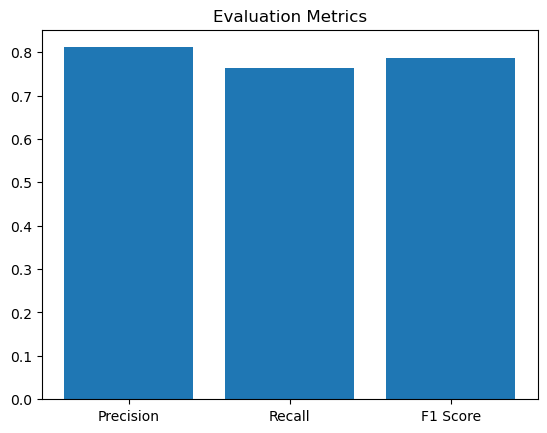

In [8]:
def evaluate_model(model, test_loader):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # plotting metrics
    metrics = {"Precision": precision, "Recall": recall, "F1 Score": f1}
    plt.bar(metrics.keys(), metrics.values())
    plt.title("Evaluation Metrics")
    plt.show()

# evaluate the model
evaluate_model(model, test_loader)


# 2 Topic Modeling

In [9]:
#we reimport everything we need, for the sake of making clear what libraries are used in this section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

In [10]:
data = pd.read_csv("C:/Users/eloua/Desktop/text mining/project 2/abcnews-date-text.csv")

#### basic data inspection and changes

In [11]:
#some basic data inspection. The headlines seem to be already sufficiently preprocessed, so no further preprocessing will be applied
data.head()

publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers

In [12]:
#making sure there are no missing values, which is not the case
zero_count = data['headline_text'].isna().sum()
zero_count

0

In [13]:
print(f"Total articles: {data.shape[0]}")

Total articles: 1244184


In [14]:
# Convert publish date to datetime
data['publish_date'] = pd.to_datetime(data['publish_date'], format='%Y%m%d')
data

publish_date                                      headline_text
0         2003-02-19  aba decides against community broadcasting lic...
1         2003-02-19     act fire witnesses must be aware of defamation
2         2003-02-19     a g calls for infrastructure protection summit
3         2003-02-19           air nz staff in aust strike for pay rise
4         2003-02-19      air nz strike to affect australian travellers
...              ...                                                ...
1244179   2021-12-31  two aged care residents die as state records 2...
1244180   2021-12-31  victoria records 5;919 new cases and seven deaths
1244181   2021-12-31    wa delays adopting new close contact definition
1244182   2021-12-31  western ringtail possums found badly dehydrate...
1244183   2021-12-31  what makes you a close covid contact here are ...

[1244184 rows x 2 columns]

A document-term matrix is created which we will be using further on. Throughout this notebook, the number of topics for both PLSI and LDA is set to 10 and 20, which is relatively low. Given the size of the data set, a much larger amount of topics could be selected. However, due to computational restrictions, and in order to keep the interpretability of the results high, these numbers were deliberately kept low.

In [15]:
# Create a document-term matrix
#3000 features selected, which is relatively small given the very large dataset. This was done due to computational limitations
vectorizer = CountVectorizer(stop_words='english', max_features=3000, min_df=2, max_df=0.95)
dt_matrix = vectorizer.fit_transform(data['headline_text'])
feature_names = vectorizer.get_feature_names_out() # Get vocabulary words (feature names)

print(f"Shape of Document-Term Matrix: {dt_matrix.shape}")

Shape of Document-Term Matrix: (1244184, 3000)


## Probabilistic Latent Semantic Analysis (PLSI)
We will be building the PSLA using the expectation-maximization algorithm that involves the following features:

- Document-Term Matrix:
    Built previously using CountVectorizer, representing the frequency of words in each document

- Initialization:
    P(z∣d) and P(w∣z) are randomly initialized and normalized

- E-Step:
    Computes the posterior probability P(z∣d,w) for each document-word pair

- M-Step:
    Updates P(w∣z) and P(z∣d) based on the posterior probabilities

- Convergence Check:
    Monitors log-likelihood to determine when to stop iterations

- Topic Display:
    Displays the top words associated with each topic based on P(w∣z)P(w∣z)

n_iters which controls the number of iterations (epochs) is set to 5, due to computational restraints

In [16]:
%%time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix

# Converted the document-term matrix to a sparse matrix using csr_matrix for memory efficiency
dt_matrix = csr_matrix(dt_matrix)

# Hyperparameters
n_docs, n_words = dt_matrix.shape
n_topics = 10
n_iters = 5  # Reduce iterations for testing. Normally convergence would be used, but it takes too much time.
tol = 1e-4

# Step 1: Initialize probabilities
P_z_given_d = np.random.rand(n_docs, n_topics)
P_z_given_d = normalize(P_z_given_d, norm='l1', axis=1)

P_w_given_z = np.random.rand(n_topics, n_words)
P_w_given_z = normalize(P_w_given_z, norm='l1', axis=1)

#tracker of the log-likelihood of the model to monitor convergence. Initialized at minus infinity
prev_log_likelihood = -np.inf

# Step 2: EM Algorithm
for iteration in range(n_iters):
    print(f"Iteration {iteration + 1}")

    # E-Step: Compute P(z | d, w) on-the-fly
    for d in range(n_docs):
        doc_indices = dt_matrix[d].indices  # non-zero indices, i.e. words with non-zero counts in document d
        for w in doc_indices:
            prob = P_z_given_d[d, :] * P_w_given_z[:, w]
            norm_prob = prob / np.sum(prob) if np.sum(prob) > 0 else 0 #normalize the probability
            for z in range(n_topics):
                P_w_given_z[z, w] += dt_matrix[d, w] * norm_prob[z]

    # Normalize P(w | z), row-wise, so that probabilities sum to 1
    P_w_given_z /= np.sum(P_w_given_z, axis=1, keepdims=True)

    # M-Step: Update P(z | d)
    for d in range(n_docs):
        doc_indices = dt_matrix[d].indices  # Non-zero indices
        for z in range(n_topics):
            prob_sum = 0
            for w in doc_indices:
                prob_sum += dt_matrix[d, w] * P_w_given_z[z, w]
            P_z_given_d[d, z] = prob_sum
        P_z_given_d[d, :] /= np.sum(P_z_given_d[d, :])

    # Compute log-likelihood of current model
    log_likelihood = 0
    for d in range(n_docs):
        doc_indices = dt_matrix[d].indices
        for w in doc_indices:
            prob = np.sum(P_z_given_d[d, :] * P_w_given_z[:, w])
            if prob > 0:
                log_likelihood += dt_matrix[d, w] * np.log(prob)

    print(f"Log-Likelihood: {log_likelihood:.4f}")

    # Check convergence. We do not really use this, since we fixed the number of iterations to only 5. Still left in the code for demonstration
    if abs(log_likelihood - prev_log_likelihood) < tol:
        print("Converged!")
        break
    prev_log_likelihood = log_likelihood


Iteration 1


<timed exec>:49: RuntimeWarning: invalid value encountered in divide


Log-Likelihood: -34364882.8349
Iteration 2
Log-Likelihood: -32463647.9514
Iteration 3
Log-Likelihood: -31219827.3866
Iteration 4
Log-Likelihood: -30832875.7351
Iteration 5
Log-Likelihood: -30674781.2159
CPU times: total: 2h 8min 1s
Wall time: 2h 8min 10s


In [17]:
# Display and extract the most significant words associated with each topic in the PLSA model
# Take only the top 5, to increase interpretability
def display_plsa_topics(P_w_given_z, vocab, n_top_words=5):
    topics = []
    for topic_idx, topic_dist in enumerate(P_w_given_z):
        top_words = [vocab[i] for i in np.argsort(topic_dist)[-n_top_words:][::-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
        topics.append(top_words)
    return topics

top_5_words_per_topic = display_plsa_topics(P_w_given_z, feature_names)

Topic 1: wa, water, day, school, abc
Topic 2: govt, sydney, death, government, coast
Topic 3: council, crash, woman, urged, drug
Topic 4: new, australia, interview, report, car
Topic 5: nsw, australian, attack, claims, year
Topic 6: win, killed, rural, cup, help
Topic 7: qld, sa, home, coronavirus, set
Topic 8: police, man, court, murder, south
Topic 9: says, world, mp, centre, family
Topic 10: plan, health, hospital, nt, trial


the ten extracted topics are not always so clear in terms of interpretability. This is likely due to the fact that only ten topics were extracted (which was done due to computational limitations). The following are interpretations of the ten topics:
-topic 1: Relating to news in WA regarding education, water-related problems, and other miscellaneous daily events.-tTopic 2: Probably related to governmental news in Sydney and coastal regions, perhaps involving policy, disasters, or fatalities.-t
Topic 3: This could pertain to local council matters, traffic incidents, and public health campaigns on drug usage or safety awareness. Not a very clearotopic-t
Topic 4: General news, including interviews, reports on various topics, and news related to cars (e.g., road accidents-t.
Topic 5: News centered on New South Wales (nsw) with a focus on conflicts, legal claims, or yearly reviews of significant even-ts.
Topic 6: News on sports or rural focus, possibly involving competitions (like a cup), fatalities, and community -tid.
Topic 7: Headlines featuring news of Queensqldd (QLD) and South Australia (sa), including COVID-19 and housing is-tues.
Topic 8: Crime and legal news, involving cases of murder or major police actions in southern regions of Aust-talia.
Topic 9: Political and global news, including statements from Members of Parliament (mp) and issues affecting families or community c-tnters.
Topic 10: Health-related topics, focusing on hospitals, medical trials, and Northern Territory (nt) planning or initiatives.

### Temporal Evolution of Topics
Now, we will study the evolution of the topics over time. Here, we consider tracking over the years not months. we do this by:
- Assign dominant topic to each headline using the matrix gotten from the plsa model.
- group the data by the year they were published and the dominant topics for that year.
- Normalize the frequency by dividing by the total number of abc news articles for the corresponding year.
- Then, we plot the topics trends over time.

In [19]:
# assign the dominant topic to each document based on the highest topic probability
d = data.copy()
d['dominant_topic'] = np.argmax(P_z_given_d, axis=1)

# Extract publication year from the publish_date column
d['publish_year'] = data['publish_date'].dt.year


In [20]:
# group data by year and dominant topic, counting the number of documents per group
topic_trends = d.groupby(['publish_year', 'dominant_topic']).size().unstack(fill_value=0)
topic_trends

dominant_topic      0     1     2      3     4     5     6      7     8     9
publish_year                                                                 
2003             5713  6469  6124   7097  6128  6027  5792   8939  5755  5953
2004             6375  7370  7262   8085  6975  6806  6591  10304  6035  6871
2005             6559  8086  7227   7595  6900  6211  6630  10258  6657  7001
2006             6254  7457  6478   7191  6145  5959  6135   9272  5796  6214
2007             7472  8528  7554   8494  6959  6376  6910  11854  6269  6758
2008             7436  8731  7356   8675  6832  6930  7938  12659  6544  6890
2009             8148  7283  6977   9312  6588  6676  7474  11567  5894  6525
2010             7200  6525  7351  10046  6563  6564  6905  11234  5883  6660
2011             9042  7213  7177   9242  7123  7637  7039  10543  6032  6730
2012            11113  8081  7849  11405  8684  7704  7743  11691  6760  7978
2013            10128  8234  7809  12030  9316  8637  8466  11905  7447  7956
2014             8363  7420  6483  10932  8942  7590  7570  10065  7175  6991
2015             8132  7257  6272  10016  8209  6454  6979   9953  7257  6761
2016             6524  5895  4729   8026  6547  4792  5391   8058  5655  5957
2017             5206  4607  3560   6075  4963  3638  4059   5928  4459  5016
2018             4179  3860  3038   5027  4143  2887  3592   5198  4135  4043
2019             3806  3252  2674   4709  3521  2332  2704   4548  3048  3466
2020             3309  3348  2293   5854  3785  1987  9406   4316  2571  3371
2021             1660  1495   960   2877  2024  1133  2603   1792  1706  1676

In [21]:
# normalize topic trends by year (row-wise normalization for relative frequencies)
topic_trends_normalized = topic_trends.div(topic_trends.sum(axis=1), axis=0)
topic_trends_normalized

dominant_topic         0         1         2         3         4         5  \
publish_year                                                                 
2003            0.089270  0.101083  0.095692  0.110896  0.095754  0.094176   
2004            0.087721  0.101412  0.099926  0.111250  0.095977  0.093651   
2005            0.089697  0.110579  0.098832  0.103865  0.094360  0.084938   
2006            0.093481  0.111463  0.096830  0.107487  0.091852  0.089072   
2007            0.096820  0.110504  0.097883  0.110063  0.090173  0.082618   
2008            0.092960  0.109150  0.091960  0.108450  0.085410  0.086635   
2009            0.106588  0.095272  0.091269  0.121815  0.086181  0.087332   
2010            0.096088  0.087080  0.098104  0.134070  0.087587  0.087601   
2011            0.116254  0.092738  0.092275  0.118825  0.091581  0.098190   
2012            0.124854  0.090790  0.088183  0.128135  0.097564  0.086554   
2013            0.110173  0.089570  0.084947  0.130863  0.101340  0.093954   
2014            0.102574  0.091008  0.079516  0.134084  0.109676  0.093093   
2015            0.105214  0.093893  0.081149  0.129590  0.106210  0.083504   
2016            0.105954  0.095738  0.076802  0.130347  0.106327  0.077825   
2017            0.109575  0.096967  0.074930  0.127865  0.104460  0.076572   
2018            0.104209  0.096255  0.075757  0.125355  0.103312  0.071991   
2019            0.111744  0.095479  0.078509  0.138256  0.103376  0.068467   
2020            0.082232  0.083201  0.056983  0.145477  0.094061  0.049379   
2021            0.092603  0.083398  0.053553  0.160493  0.112909  0.063204   

dominant_topic         6         7         8         9  
publish_year                                            
2003            0.090504  0.139678  0.089926  0.093020  
2004            0.090693  0.141784  0.083042  0.094546  
2005            0.090668  0.140282  0.091037  0.095741  
2006            0.091703  0.138593  0.086635  0.092884  
2007            0.089538  0.153601  0.081232  0.087568  
2008            0.099236  0.158255  0.081809  0.086135  
2009            0.097771  0.151313  0.077102  0.085357  
2010            0.092151  0.149925  0.078512  0.088882  
2011            0.090501  0.135552  0.077554  0.086528  
2012            0.086992  0.131348  0.075948  0.089632  
2013            0.092094  0.129504  0.081009  0.086546  
2014            0.092848  0.123450  0.088003  0.085747  
2015            0.090296  0.128775  0.093893  0.087476  
2016            0.087553  0.130867  0.091841  0.096745  
2017            0.085433  0.124771  0.093852  0.105576  
2018            0.089572  0.129619  0.103112  0.100818  
2019            0.079389  0.133529  0.089489  0.101762  
2020            0.233748  0.107256  0.063892  0.083772  
2021            0.145208  0.099967  0.095169  0.093495

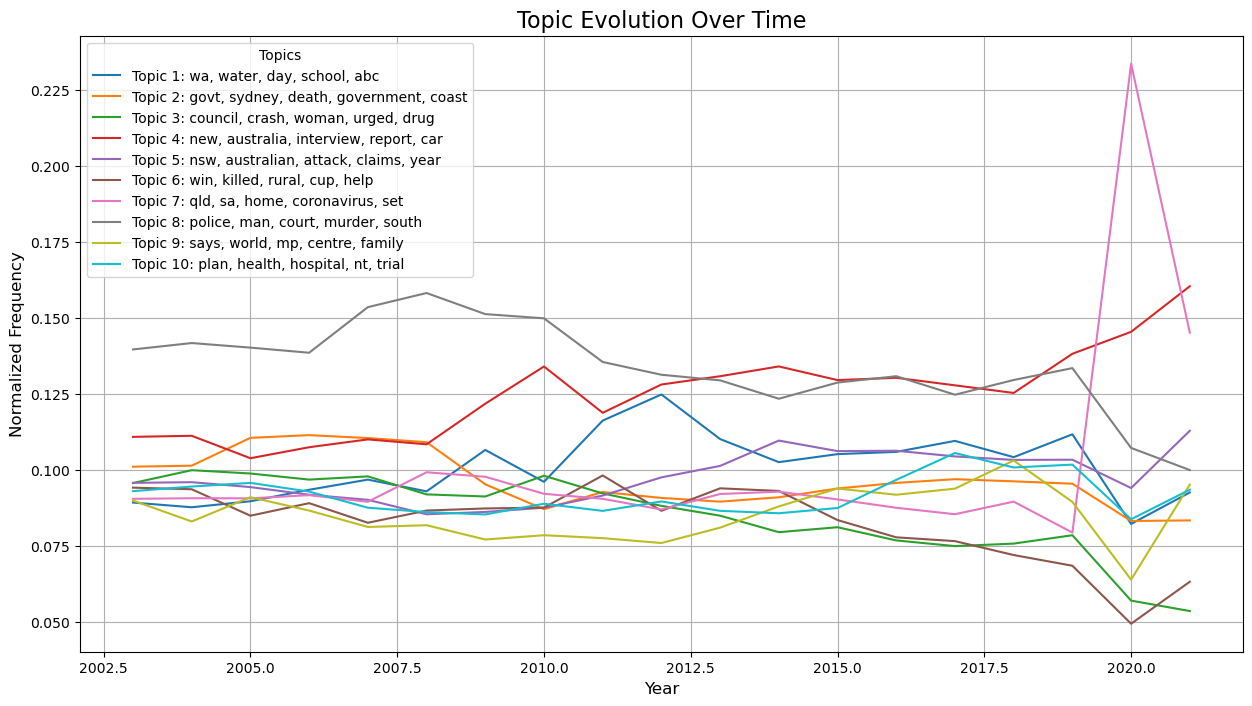

In [22]:
# plot topic trends with labels for the top 5 words in each topic
plt.figure(figsize=(15, 8))

for topic_idx in range(n_topics):
    # plot the normalized frequency for each topic over time
    plt.plot(topic_trends_normalized.index, topic_trends_normalized[topic_idx], label=f'Topic {topic_idx + 1}: {", ".join(top_5_words_per_topic[topic_idx])}')

# add plot details
plt.title("Topic Evolution Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)
plt.legend(title="Topics", fontsize=10)
plt.grid(True)
plt.show()

#### Interpretation over time (PLSA)
Most topics remain relatively consistent in frequency over time, except for the period 2019 - 2020. At that point in time, the topic containing "coronavirus" surges, while all other topics (except topic 4) decline. This is of course due to COVID-19, which dominated the news globally during that period in time. Topic 8, the topic on murder is on a general decline, while topic 4 on a general incline over the years, perhaps indicating more sensational news topics rather than hard crime reporting. Topic 6 (the rural news topic) also is in decline since 2014, indicating less local news coverage. For the first 5 years, 7 out of the 10 topics seem to receive a similar amount of coverage (topics 1, 3, 5, 6, 7, 9, 10), which diverges over time, with some topics receiving clearly more coverage (1, 2, 10) and others clearly less (3, 6).

## LDA

In [23]:
#we can select more features here, since the code for the LDA is better optimized
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
dt_matrix = vectorizer.fit_transform(data['headline_text'])
feature_names = vectorizer.get_feature_names_out() # Get vocabulary words (feature names)

print(f"Shape of Document-Term Matrix: {dt_matrix.shape}")

Shape of Document-Term Matrix: (1244184, 5000)


In [24]:
# apply LDA

n_topics = 20  # Number of topics to extract. Here we can use more topics, since the algorithm is faster.
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,        # Set random state for reproducibility
    learning_method='online'  # Use online learning for efficiency with large datasets
)
lda_matrix = lda.fit_transform(dt_matrix)

In [25]:
# Function to display top words for each topic
def display_lda_topics(model, feature_names, no_top_words, n_labels=5):

    topics = []  # Store top words for each topic
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")  # Topic index gotten above
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(top_words[:n_labels])  # Store top 2 words for each topic for labeling later
        print(", ".join(top_words))  # Print top words for the topic
    return topics

# Fetch feature names (e.g., terms) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Display topics and fetch top 5 words for each topic
top_2_words_per_topic = display_lda_topics(lda, feature_names, no_top_words=5)

Topic 1:
day, crash, funding, changes, weather
Topic 2:
interview, north, attack, west, final
Topic 3:
home, win, killed, case, return
Topic 4:
police, coast, charged, man, car
Topic 5:
australian, health, state, market, border
Topic 6:
cup, indigenous, donald, set, federal
Topic 7:
court, world, school, country, trial
Topic 8:
says, woman, nt, child, govt
Topic 9:
budget, deal, act, pm, abuse
Topic 10:
qld, china, rural, hospital, test
Topic 11:
covid, election, 19, national, dies
Topic 12:
australia, record, second, million, defends
Topic 13:
sydney, sa, calls, water, plan
Topic 14:
government, sex, royal, war, hour
Topic 15:
nsw, wa, report, adelaide, perth
Topic 16:
new, coronavirus, trump, news, year
Topic 17:
man, melbourne, open, dead, tasmania
Topic 18:
council, victoria, canberra, accused, wins
Topic 19:
death, south, abc, labor, help
Topic 20:
queensland, missing, family, ban, life


The topics found using LDA are again not always clear. Here are some interpretations of topics:
-topic 1: Probably mirrors some day-to-day news reports about accidents (crashes), announcements of funding, policy changes, and weather
-topic 2: Could represent interviews or reports on events occurring in northern and western regions of Australia, including conflicts or sports finals
-topic 9: Primarily political and economic, focusing on budgets, legislative deals, the Prime Minister (pm), and issues such as abuse
-topic 11: Focuses on COVID-19, national elections, and deaths, reflecting pandemic and political coverage

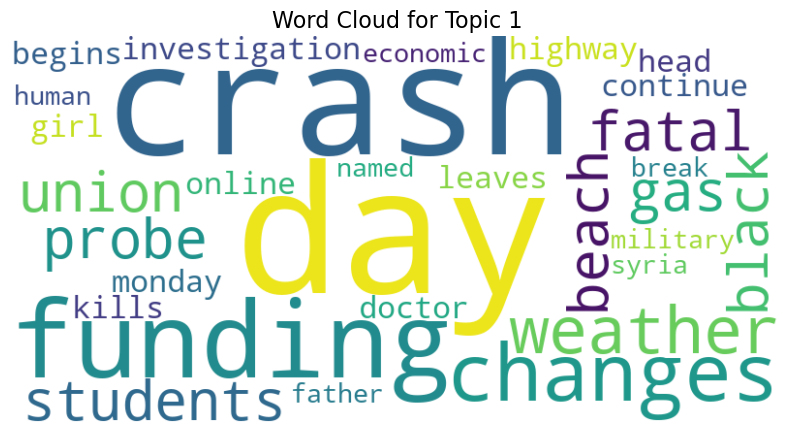

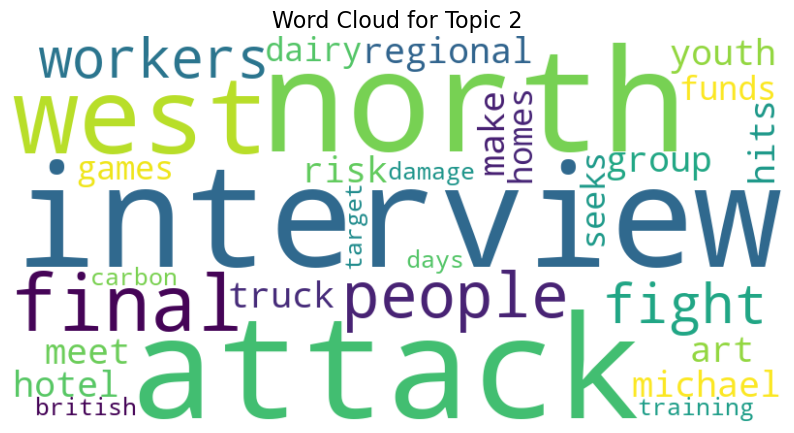

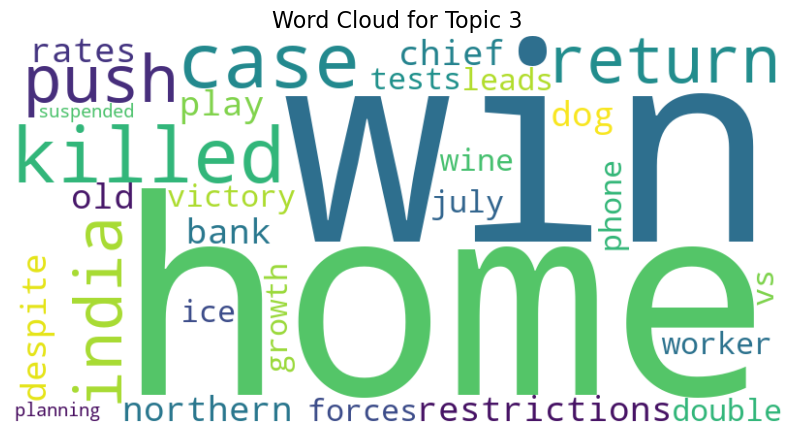

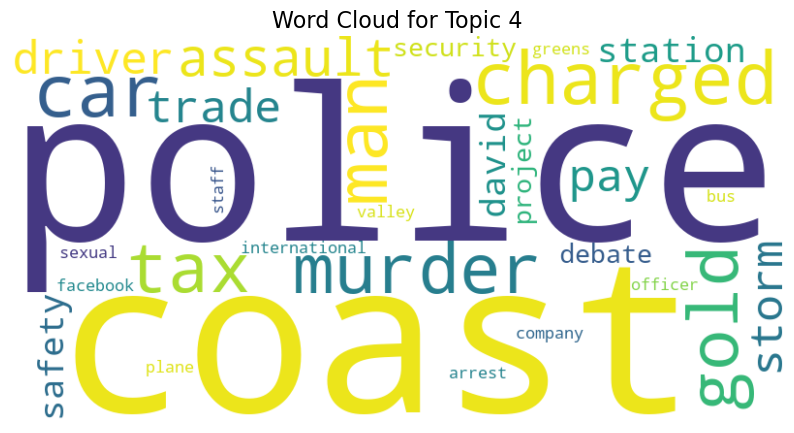

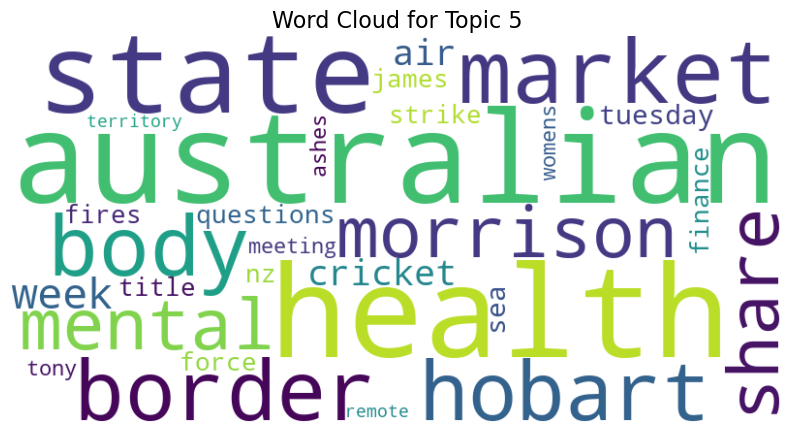

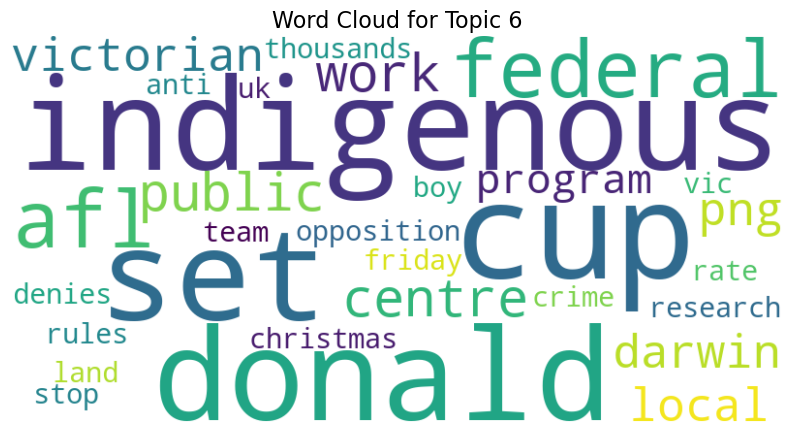

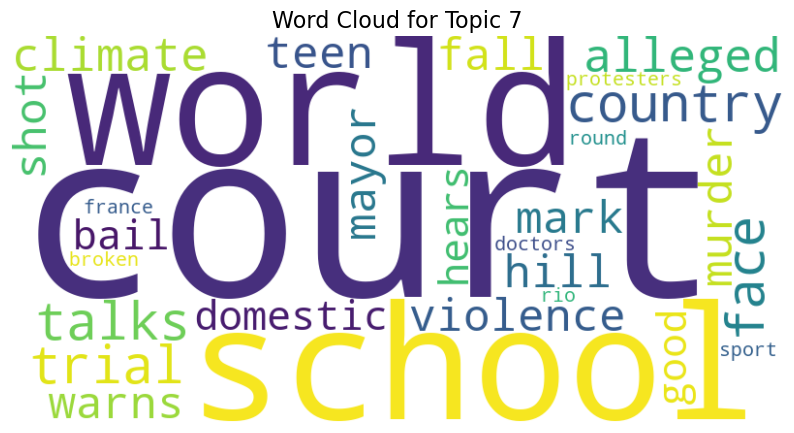

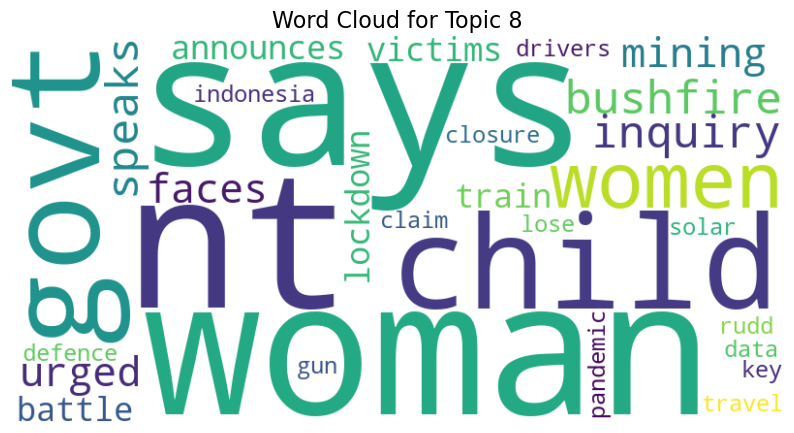

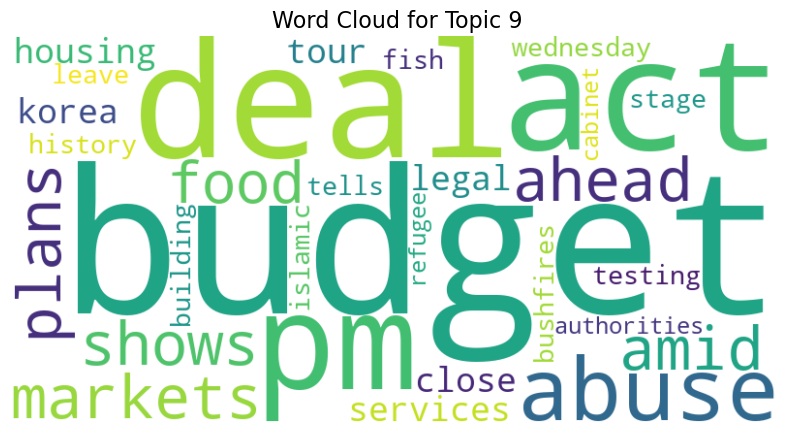

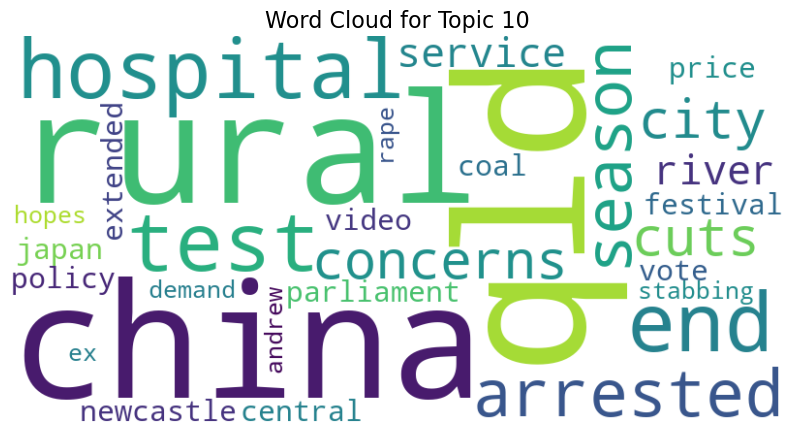

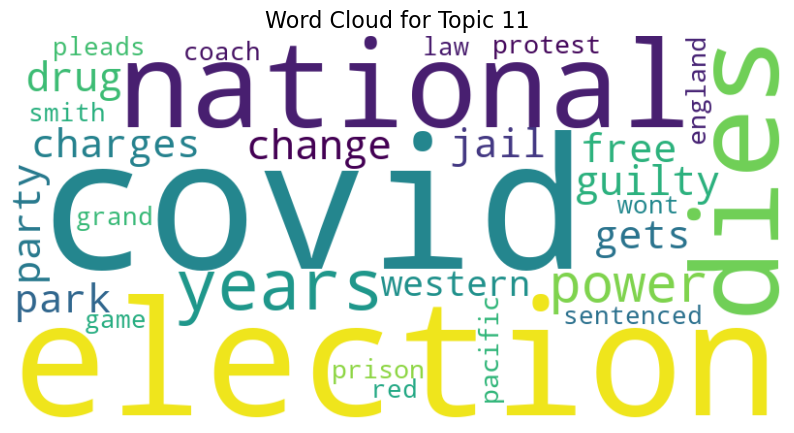

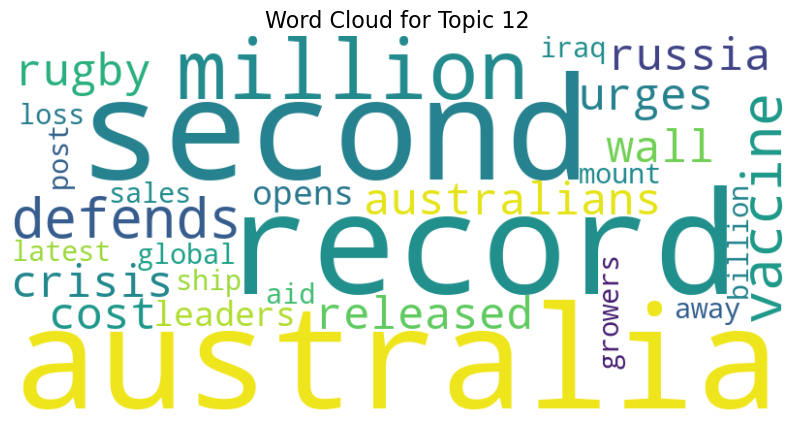

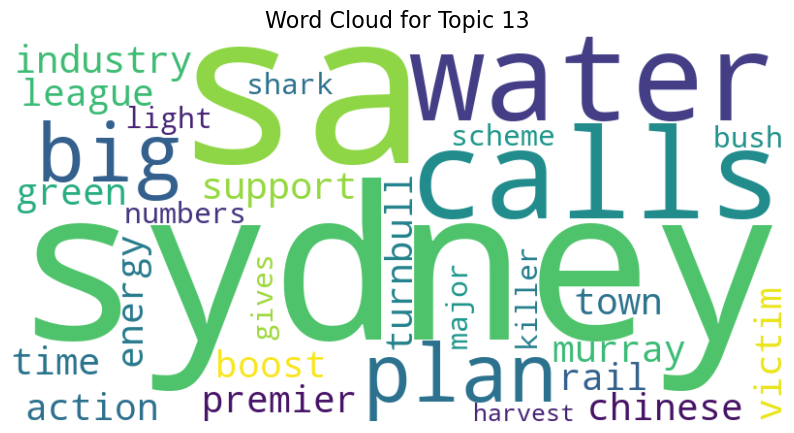

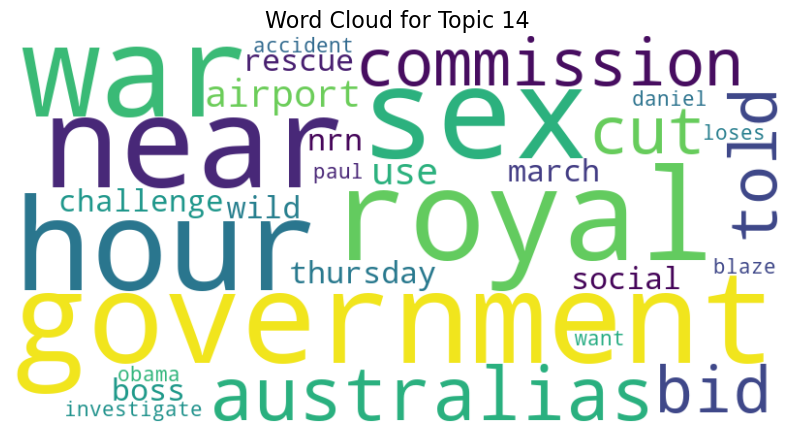

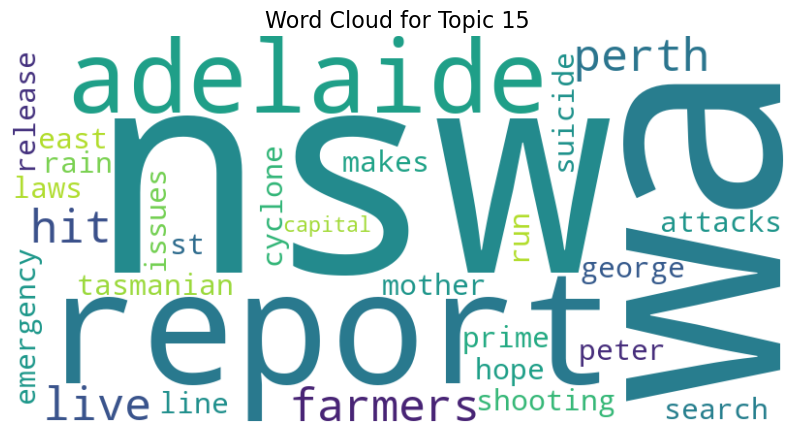

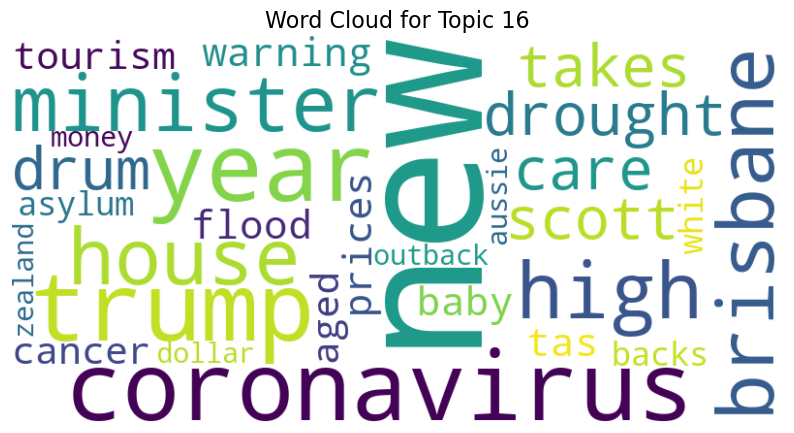

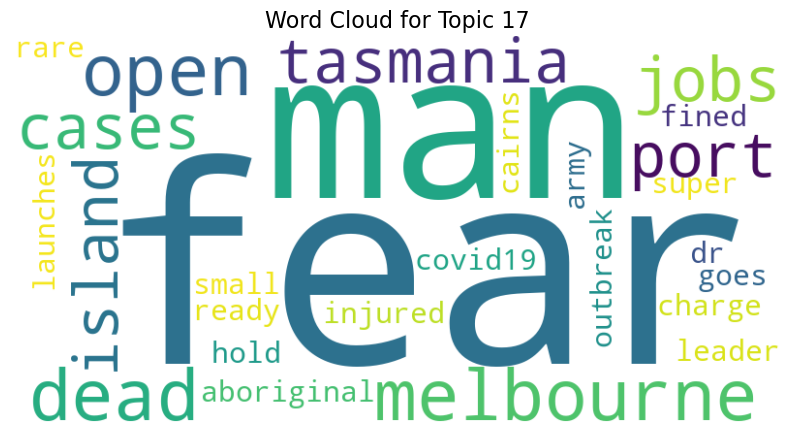

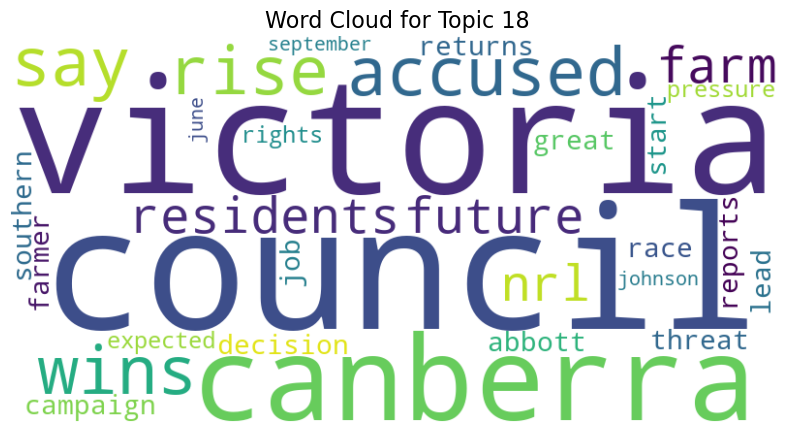

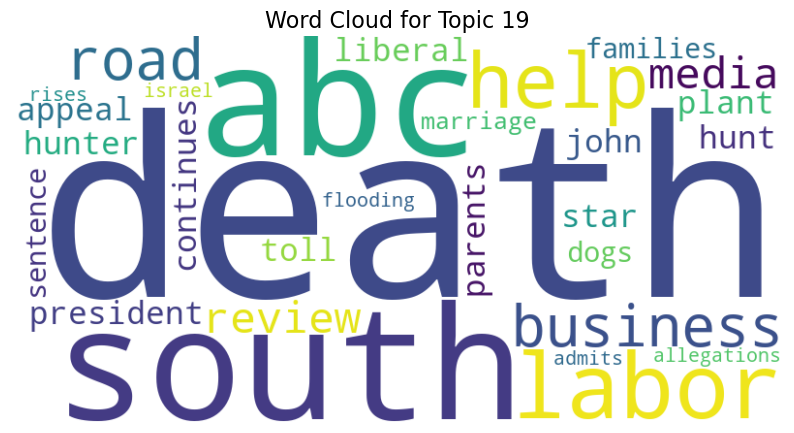

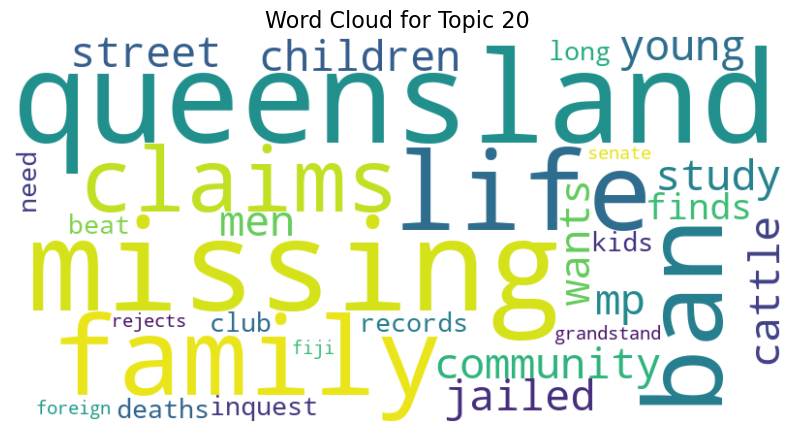

In [30]:
# word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(
        " ".join([feature_names[i] for i in topic.argsort()[:-30 - 1:-1]])
    )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {topic_idx + 1}", fontsize=16)
    plt.show()

### Temporal Evolution of Topics
We use the same method as for PLSA. The steps are repeated below:
Now, we will study the evolution of derived topics over time. Here, we consider tracking over the years not months. we do this by:
- Assign dominant topic to each headline using the matrix gotten from the LDA model
- group the data by the year they were published and the dominant topics for that year
- Normalize the frequency by dividing by the total number of abc news articles for the corresponding year
- Then, we plot the topics trends over time

In [26]:
# assign the dominant topic to each document based on the highest topic probability
data['dominant_topic'] = np.argmax(lda_matrix, axis=1)

# extract publication year from the publish_date column
data['publish_year'] = data['publish_date'].dt.year

# group data by year and dominant topic, counting the number of documents per group
topic_trends = data.groupby(['publish_year', 'dominant_topic']).size().unstack(fill_value=0)

# normalize topic trends by year (row-wise normalization for relative frequencies)
topic_trends_normalized = topic_trends.div(topic_trends.sum(axis=1), axis=0)

In [27]:
topic_trends

dominant_topic    0     1     2     3     4     5     6     7     8     9   \
publish_year                                                                 
2003            3339  3301  4396  3642  2116  3333  3555  4031  3241  3078   
2004            3993  3666  5034  4521  2415  3572  3690  4575  3796  3466   
2005            4035  3915  4519  4793  2641  3524  3818  5155  3525  3505   
2006            3679  3260  4096  4113  2445  3273  3455  4503  3520  3111   
2007            4326  3360  4535  5348  2570  3509  4118  5416  4044  3660   
2008            4381  3999  4955  5744  2939  3302  4408  5430  3824  4254   
2009            4637  5266  4548  4982  2655  3106  4164  5182  3462  3544   
2010            4549  6187  4437  5132  2708  3227  4130  3919  3309  3316   
2011            5016  5254  4380  4790  2740  3312  4100  3683  3744  3692   
2012            5805  6342  4501  5129  3633  3554  4648  4369  4315  4615   
2013            5666  6030  4396  5271  3880  3769  4850  4914  4698  5425   
2014            4458  5253  4062  4321  3570  3435  5051  3816  3823  4752   
2015            3919  3860  3970  4287  3677  3288  4561  3941  3623  3986   
2016            3070  2957  2851  3591  2870  2502  3187  3215  2892  3123   
2017            2282  2610  2189  2441  2379  2059  2538  2563  2276  2098   
2018            2124  1974  1915  2309  2107  1598  2286  2315  1927  1729   
2019            1695  1531  1552  1906  1850  1363  1653  1798  1759  1432   
2020            1703  1600  1839  2006  1822  1652  1609  2044  1597  1402   
2021             781   755   852   792   818   699   681  1162   686   727   

dominant_topic    10    11    12    13    14    15    16    17    18    19  
publish_year                                                                
2003            2661  3084  4052  2312  2888  2660  3001  3697  2867  2743  
2004            2969  3553  4733  2542  2994  3117  3275  4237  3384  3142  
2005            2941  3412  4609  2371  3095  3091  3145  4241  3451  3338  
2006            2609  3144  4567  2224  2865  2788  2693  3872  3734  2950  
2007            3285  3190  5469  2611  3346  3168  3261  4308  4288  3362  
2008            3367  3397  5545  2940  3355  3319  3558  4036  3916  3322  
2009            3031  2917  5044  2892  3134  3158  3649  4137  3786  3150  
2010            3482  2879  4519  2821  2653  3262  3352  4204  3689  3156  
2011            3251  3027  4603  3177  3443  3620  3509  4237  4770  3430  
2012            3726  3601  5344  3549  4125  3739  3868  4698  5717  3730  
2013            4033  3765  5314  3940  4136  4185  3902  4907  5014  3833  
2014            3273  3912  4854  3933  3933  3629  3723  4474  3650  3609  
2015            3142  3790  4683  3423  4256  3685  3728  3997  3712  3762  
2016            3015  3110  3727  3051  3301  2999  3025  2980  2980  3128  
2017            2199  2637  2812  2238  2458  2591  2133  2192  2470  2346  
2018            1821  2284  2191  1953  1935  2185  1817  1624  2098  1910  
2019            2008  1852  1879  1529  1729  1899  1563  1439  2025  1598  
2020            3260  2335  1906  1561  1822  4956  2030  1711  1630  1755  
2021            1693  1318   935   732   900  1276   876   719   813   711

In [28]:
topic_trends_normalized

dominant_topic        0         1         2         3         4         5   \
publish_year                                                                 
2003            0.052174  0.051581  0.068691  0.056909  0.033064  0.052081   
2004            0.054944  0.050444  0.069268  0.062209  0.033231  0.049151   
2005            0.055180  0.053539  0.061799  0.065546  0.036117  0.048192   
2006            0.054992  0.048729  0.061225  0.061479  0.036547  0.048923   
2007            0.056055  0.043538  0.058763  0.069298  0.033301  0.045469   
2008            0.054769  0.049993  0.061944  0.071808  0.036742  0.041280   
2009            0.060659  0.068887  0.059495  0.065172  0.034731  0.040631   
2010            0.060709  0.082569  0.059214  0.068490  0.036140  0.043066   
2011            0.064491  0.067551  0.056314  0.061586  0.035228  0.042583   
2012            0.065219  0.071252  0.050568  0.057624  0.040817  0.039929   
2013            0.061635  0.065595  0.047820  0.057338  0.042207  0.040999   
2014            0.054679  0.064429  0.049822  0.052998  0.043787  0.042131   
2015            0.050705  0.049942  0.051365  0.055466  0.047574  0.042541   
2016            0.049859  0.048024  0.046302  0.058320  0.046611  0.040634   
2017            0.048031  0.054935  0.046074  0.051378  0.050073  0.043337   
2018            0.052965  0.049224  0.047753  0.057578  0.052541  0.039848   
2019            0.049765  0.044950  0.045567  0.055960  0.054316  0.040018   
2020            0.042321  0.039761  0.045701  0.049851  0.045278  0.041054   
2021            0.043568  0.042118  0.047529  0.044182  0.045632  0.038994   

dominant_topic        6         7         8         9         10        11  \
publish_year                                                                 
2003            0.055549  0.062987  0.050643  0.048096  0.041580  0.048190   
2004            0.050775  0.062952  0.052233  0.047692  0.040854  0.048890   
2005            0.052213  0.070497  0.048206  0.047932  0.040219  0.046660   
2006            0.051643  0.067308  0.052615  0.046502  0.038998  0.046995   
2007            0.053360  0.070179  0.052401  0.047425  0.042566  0.041335   
2008            0.055106  0.067883  0.047805  0.053181  0.042092  0.042467   
2009            0.054471  0.067788  0.045288  0.046361  0.039650  0.038159   
2010            0.055117  0.052301  0.044161  0.044254  0.046469  0.038422   
2011            0.052714  0.047353  0.048137  0.047468  0.041798  0.038918   
2012            0.052220  0.049085  0.048479  0.051849  0.041861  0.040457   
2013            0.052759  0.053455  0.051105  0.059014  0.043871  0.040956   
2014            0.061952  0.046804  0.046890  0.058285  0.040144  0.047982   
2015            0.059012  0.050990  0.046875  0.051572  0.040652  0.049036   
2016            0.051759  0.052214  0.046968  0.050719  0.048965  0.050508   
2017            0.053419  0.053945  0.047905  0.044158  0.046284  0.055503   
2018            0.057005  0.057728  0.048052  0.043115  0.045409  0.056955   
2019            0.048532  0.052789  0.051644  0.042043  0.058955  0.054375   
2020            0.039985  0.050795  0.039687  0.034841  0.081014  0.058027   
2021            0.037990  0.064822  0.038268  0.040556  0.094444  0.073524   

dominant_topic        12        13        14        15        16        17  \
publish_year                                                                 
2003            0.063315  0.036127  0.045127  0.041564  0.046893  0.057768   
2004            0.065126  0.034978  0.041198  0.042890  0.045064  0.058301   
2005            0.063030  0.032424  0.042325  0.042271  0.043009  0.057997   
2006            0.068265  0.033243  0.042824  0.041674  0.040254  0.057877   
2007            0.070866  0.033833  0.043357  0.041050  0.042255  0.055822   
2008            0.069320  0.036754  0.041942  0.041492  0.044480  0.050456   
2009            0.065983  0.037832  0.040997  0.041311  0.047734  0.054118   
2010            0.06

C:\Users\eloua\AppData\Local\Temp\ipykernel_7828\3041506106.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_topics)  # 'tab20' colormap with n_topics distinct colors


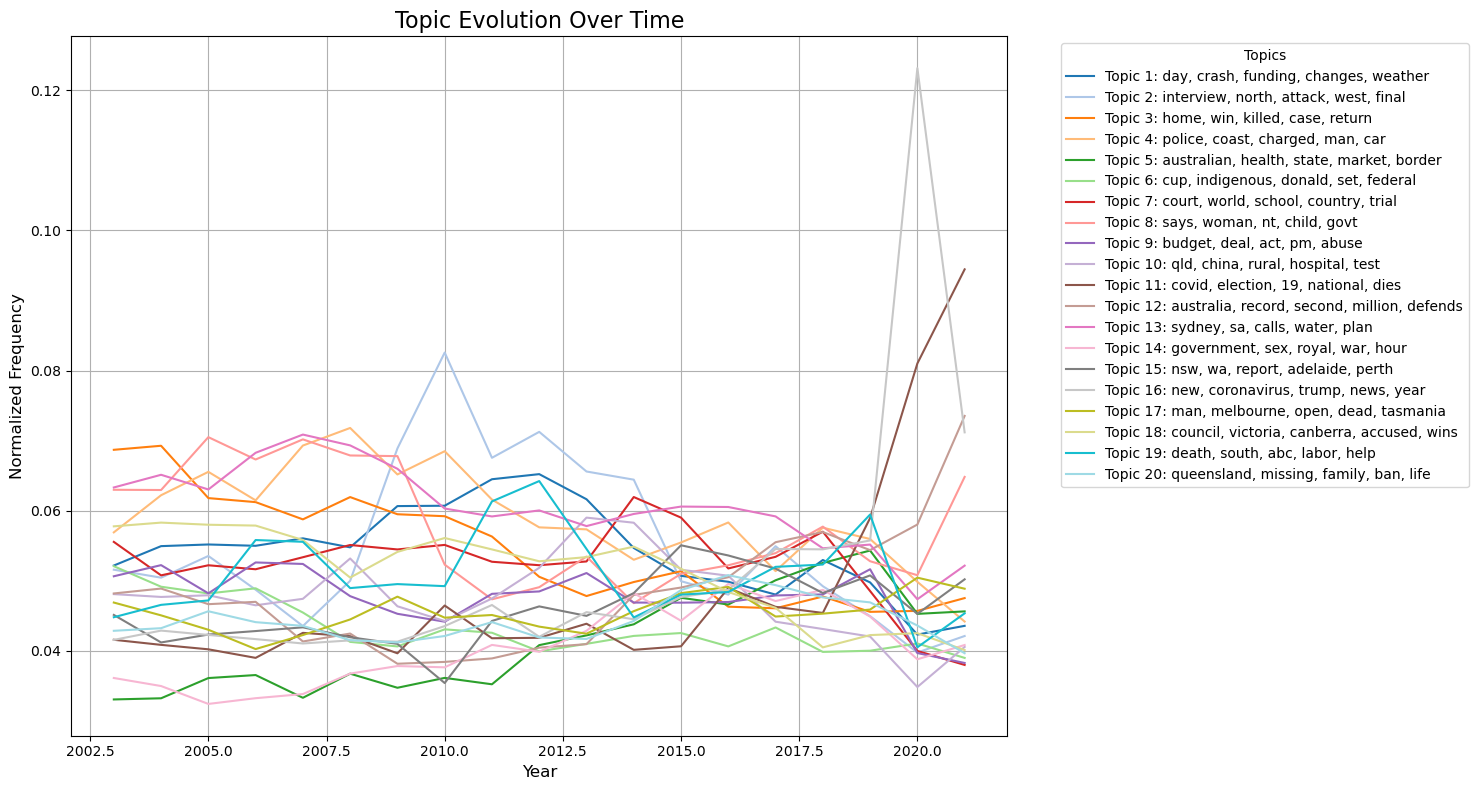

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(15, 8))

# Use a colormap to assign distinct colors to each topic, increasing readablilty
colors = cm.get_cmap('tab20', n_topics)

for topic_idx in range(n_topics):
    plt.plot(
        topic_trends_normalized.index, 
        topic_trends_normalized[topic_idx], 
        label=f'Topic {topic_idx + 1}: {", ".join(top_2_words_per_topic[topic_idx])}', 
        color=colors(topic_idx)  # Assign color from the colormap
    )

# Add plot details
plt.title("Topic Evolution Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)
plt.legend(title="Topics", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.grid(True)
plt.tight_layout()  # Ensure everything fits within the figure
plt.show()


#### Interpretation over time (LDA)
Given the larger amount of topics, the interpretation is more difficult. The topics seem to converge in frequency somewhat up until the point 2018, where they diverge again. Topics 10 and 11, which contain words related to COVID-19 and health ("China", "hospital", "test", "covid", "19"), increase sharply in frequency from 2019 onwards. Topics 3, 4, 8 and 13 which were the most frequent in the early periods, decline steadily over the timespan. These topics include topics related to crime (topics 3 and 4), statements by individuals ("says") (topic 8) and plans and water-related issues (topic 13).
Topics 5 and 14, which started at the bottom, see more coverage over time. These topics include diverse topics, (health-related topics, state-level issues, market news for topic 5; government, sexual misconduct, royal family matters, wars for topic 14).
There is a sharp increase in topic 2 from 2007 to 2010, after which it goes back in decline. This topic includes interviews and sports events ("final"). From the period 2015 to 2018, no topic really stands out, with a very diverse array of topics being covered, compared to the beginning, where the gaps between different topics were much larger.